In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import csv

In [2]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [3]:
rr_target = []
hr_target = []
rr_phase = []
hr_phase = []
ext_rr_phase = []
ext_hr_phase = []

with open('./preprocessed_data/rr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        rr_target.append(lines)
        
with open('./preprocessed_data/hr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_target.append(lines)
with open('./preprocessed_data/rr_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        rr_phase.append(lines)
        
with open('./preprocessed_data/hr_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_phase.append(lines)
with open('./preprocessed_data/ext_rr_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        ext_rr_phase.append(lines)
        
with open('./preprocessed_data/ext_hr_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        ext_hr_phase.append(lines)

In [4]:
rr_target_array = []
hr_target_array = []
rr_phase_array = []
hr_phase_array = []
ext_rr_phase_array = []
ext_hr_phase_array = []
for i in range(0, 80, 2):
    rr_target_array.append(rr_target[i])
    hr_target_array.append(hr_target[i])
    rr_phase_array.append(rr_phase[i])
    hr_phase_array.append(hr_phase[i])
    ext_rr_phase_array.append(ext_rr_phase[i])
    ext_hr_phase_array.append(ext_hr_phase[i])
    
rr_target_array = np.array(rr_target_array).astype(np.float64)
hr_target_array = np.array(hr_target_array).astype(np.float64)
rr_phase_array = np.array(rr_phase_array).astype(np.float64)
hr_phase_array = np.array(hr_phase_array).astype(np.float64)
ext_rr_phase_array = np.array(ext_rr_phase_array).astype(np.float64)
ext_hr_phase_array = np.array(ext_hr_phase_array).astype(np.float64)

In [5]:
print(rr_phase_array.shape)
print(hr_phase_array.shape)
print(rr_target_array.shape)
print(hr_target_array.shape)
print(ext_rr_phase_array.shape)
print(ext_hr_phase_array.shape)

(40, 3000)
(40, 19500)
(40, 3000)
(40, 19500)
(40, 3000)
(40, 19500)


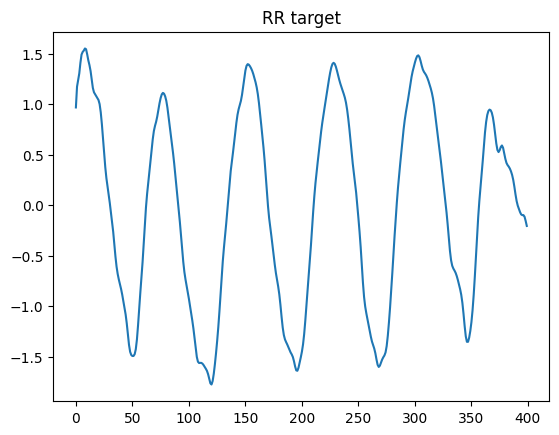

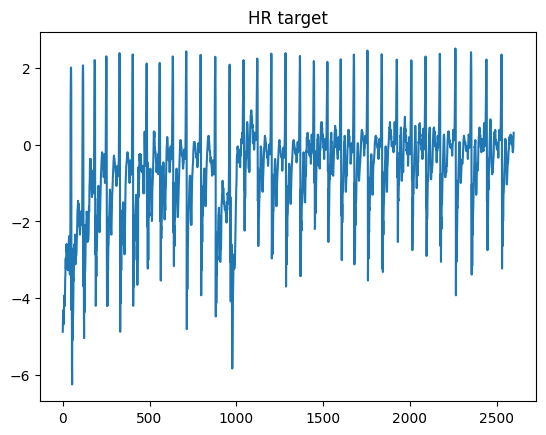

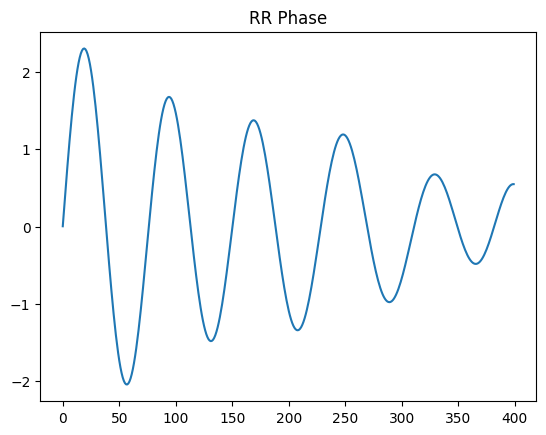

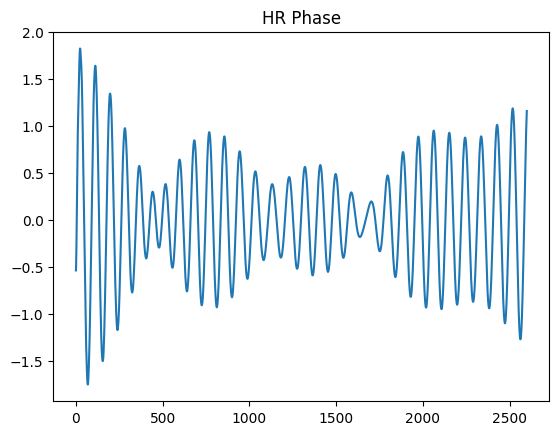

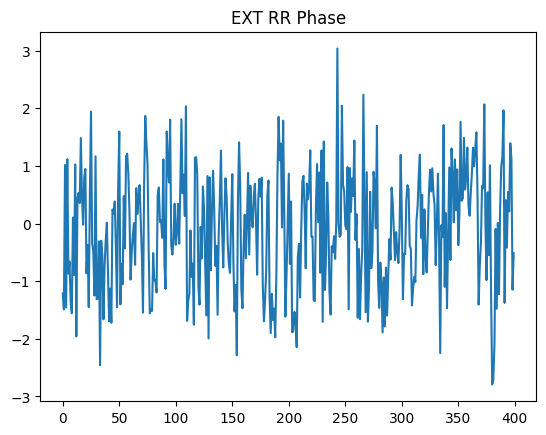

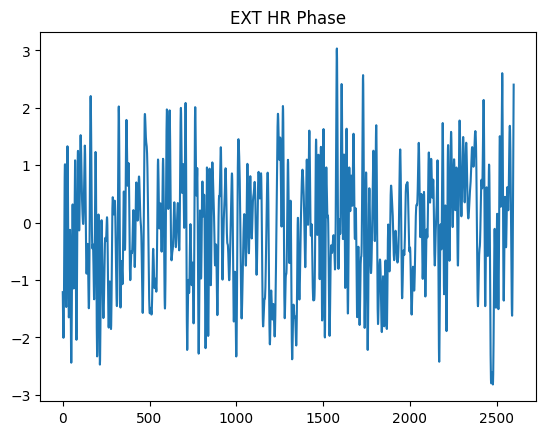

In [6]:
plt.figure(1)
plt.title("RR target")
plt.plot(rr_target_array[0][:400],label="RR target")
plt.figure(2)
plt.title("HR target")
plt.plot(hr_target_array[0][:2600],label="HR target")
plt.figure(3)
plt.title("RR Phase")
plt.plot(rr_phase_array[0][:400],label="RR Phase")
plt.figure(4)
plt.title("HR Phase")
plt.plot(hr_phase_array[0][:2600],label="HR Phase")
plt.figure(5)
plt.title("EXT RR Phase")
plt.plot(ext_rr_phase_array[0][:400],label="EXT RR Phase")
plt.figure(6)
plt.title("EXT HR Phase")
plt.plot(ext_hr_phase_array[0][:2600],label="EXT HR Phase")

In [7]:
def slide_win_rr(data):
    isi_dataVT =[]
    for k in range(len(data)):
        for i in range(101):
            if i == 0:
                index_1 = i
            else :
                index_1 = index_2 - 380
            index_2 = index_1 + 400
            vt_20s_1 = data[k][index_1:index_2]
        #print(index_1,index_2)
            isi_dataVT.append(vt_20s_1)

    return isi_dataVT

def slide_win_hr(data):
    isi_dataVT =[]
    for k in range(len(data)):
        for i in range(101):
            if i == 0:
                index_1 = i
            else :
                index_1 = index_2 - 2470
            index_2 = index_1 + 2600
            vt_20s_1 = data[k][index_1:index_2]
        #print(index_1,index_2)
            isi_dataVT.append(vt_20s_1)

    return isi_dataVT

In [8]:
slide_rr_phase = np.array(slide_win_rr(rr_phase_array))
slide_hr_phase = np.array(slide_win_hr(hr_phase_array))
slide_rr_target = np.array(slide_win_rr(rr_target_array))
slide_hr_target = np.array(slide_win_hr(hr_target_array))
slide_ext_rr = np.array(slide_win_rr(ext_rr_phase_array))
slide_ext_hr = np.array(slide_win_hr(ext_hr_phase_array))

In [9]:
print(slide_rr_phase.shape, slide_rr_target.shape, slide_hr_phase.shape, slide_hr_target.shape, slide_ext_rr.shape, slide_ext_hr.shape)

(4040, 400) (4040, 400) (4040, 2600) (4040, 2600) (4040, 400) (4040, 2600)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1_l2
import keras_tuner

def build_ecg_autoencoder():
    input_shape = (2600, 1)
    inputs = layers.Input(shape=input_shape)
    
    conv1 = layers.Conv1D(16, kernel_size=15, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    
    conv2 = layers.Conv1D(32, kernel_size=15, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)

    conv3 = layers.Conv1D(64, kernel_size=15, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)

    conv4 = layers.Conv1D(128, kernel_size=15, activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)

    up5 = layers.Conv1DTranspose(64, kernel_size=15, strides=2, padding='same', activation='relu')(conv4)
    conv5 = layers.Conv1D(64, kernel_size=15, activation='relu', padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)

    up6 = layers.Conv1DTranspose(32, kernel_size=15, strides=2, padding='same', activation='relu')(conv5)
    conv6 = layers.Conv1D(32, kernel_size=15, activation='relu', padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.Conv1DTranspose(16, kernel_size=15, strides=2, padding='same', activation='relu')(conv6)
    conv7 = layers.Conv1D(16, kernel_size=15, activation='relu', padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)

    output = layers.Conv1D(1, 1, activation='linear')(conv7)

    model = Model(inputs, output)
    model.compile(optimizer=Adam(1e-3), loss='mse')
    return model

def build_partial_finetune_model(hp):
    # Load pretrained model
    pretrained = tf.keras.models.load_model('pretrained_ecg_autoencoder.h5', custom_objects={'mse': 'mean_squared_error'})
    
    # Freeze all encoder layers (Conv1D + MaxPooling1D)
    for layer in pretrained.layers:
        if isinstance(layer, tf.keras.layers.Conv1D) or isinstance(layer, tf.keras.layers.MaxPooling1D):
            layer.trainable = False
    
    # Ganti input menjadi radar
    new_input = layers.Input(shape=(2600, 1), name='radar_input')
    x = new_input
    
    # Pasangkan dengan encoder pretrained
    for layer in pretrained.layers[1:11]:  # Ambil layer encoder sampai conv4
        x = layer(x)

    # Decoder baru (tunable)
    x = layers.Conv1DTranspose(
        filters=hp.Int('convT1_filters', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [5, 15, 25]),
        strides=2,
        padding='same',
        activation=hp.Choice('act1', ['relu', 'linear']),
        name='decoder_convT1'
    )(x)
    x = layers.Conv1D(
        filters=hp.Int('conv1_filters', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [5, 15, 25]),
        activation=hp.Choice('act2', ['relu', 'linear']),
        padding='same',
        name='decoder_conv1'
    )(x)
    x = layers.BatchNormalization(name='decoder_bn1')(x)

    x = layers.Conv1DTranspose(
        filters=hp.Int('convT2_filters', 16, 64, step=16),
        kernel_size=hp.Choice('kernel_size', [5, 15, 25]),
        strides=2,
        padding='same',
        activation=hp.Choice('act3', ['relu', 'linear']),
        name='decoder_convT2'
    )(x)
    x = layers.Conv1D(
        filters=hp.Int('conv2_filters', 16, 64, step=16),
        kernel_size=hp.Choice('kernel_size', [5, 15, 25]),
        activation=hp.Choice('act4', ['relu', 'linear']),
        padding='same',
        name='decoder_conv2'
    )(x)
    x = layers.BatchNormalization(name='decoder_bn2')(x)

    x = layers.Conv1DTranspose(
        filters=hp.Int('convT3_filters', 8, 32, step=8),
        kernel_size=hp.Choice('kernel_size', [5, 15, 25]),
        strides=2,
        padding='same',
        activation=hp.Choice('act5', ['relu', 'linear']),
        name='decoder_convT3'
    )(x)
    x = layers.Conv1D(
        filters=hp.Int('conv3_filters', 8, 32, step=8),
        kernel_size=hp.Choice('kernel_size', [5, 15, 25]),
        activation=hp.Choice('act6', ['relu', 'linear']),
        padding='same',
        name='decoder_conv3'
    )(x)
    x = layers.BatchNormalization(name='decoder_bn3')(x)

    output = layers.Conv1D(1, 1, activation='linear', name='decoder_output')(x)

    model = Model(new_input, output)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4])), loss='mse')
    return model



In [11]:
hr_train = slide_ext_hr[:3200]
hr_test = slide_ext_hr[3200:]
hr_target_train = slide_hr_target[:3200]
hr_target_test = slide_hr_target[3200:]

In [12]:
print(hr_train.shape)
print(hr_test.shape)
print(hr_target_train.shape)
print(hr_target_test.shape)

(3200, 2600)
(840, 2600)
(3200, 2600)
(840, 2600)


In [13]:
# from tensorflow.keras.callbacks import EarlyStopping

# pretrain_model = build_ecg_autoencoder()

# pretrain_model.fit(
#     hr_target_train[:2400], hr_target_train[:2400],
#     validation_data=(hr_target_train[2400:], hr_target_train[2400:]),
#     epochs=50,
#     batch_size=32,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
# )

# # Simpan pretrained model
# pretrain_model.save('pretrained_ecg_autoencoder.h5')

In [14]:
pretrain_model = tf.keras.models.load_model('pretrained_ecg_autoencoder.h5', custom_objects={'mse': 'mean_squared_error'})

pretrain_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2600, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2600, 16)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1300, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1300, 32)       │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1300, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 650, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 650, 64)        │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 650, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 325, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 325, 128)       │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 325, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 650, 64)        │       122,944 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 650, 64)        │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 650, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 1300, 32)       │        30,752 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1300, 32)       │        15,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1300, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 2600, 16)       │         7,696 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2600, 16)       │         3,856 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 405,331 (1.55 MB)

 Trainable params: 404,625 (1.54 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step


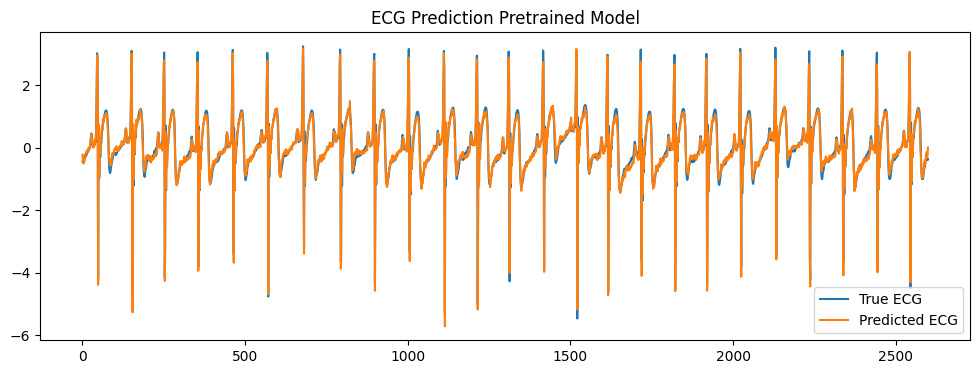

In [15]:
import matplotlib.pyplot as plt

predicted = pretrain_model.predict(hr_target_test)

plt.figure(figsize=(12, 4))
plt.plot(hr_target_test[0], label='True ECG')
plt.plot(predicted[0], label='Predicted ECG')
plt.legend()
plt.title("ECG Prediction Pretrained Model")
plt.show()

In [16]:
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_partial_finetune_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='tuner_partial_finetune',
    project_name='ext_to_ecg_decoder'
)

tuner.search(
    hr_train[:2400], hr_target_train[:2400],
    validation_data=(hr_train[2400:], hr_target_train[2400:]),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_partial_finetuned_decoder_model.h5')

Trial 30 Complete [00h 01m 00s]
val_loss: 0.9333893656730652

Best val_loss So Far: 0.9308818578720093
Total elapsed time: 02h 31m 10s


d:\Python310\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


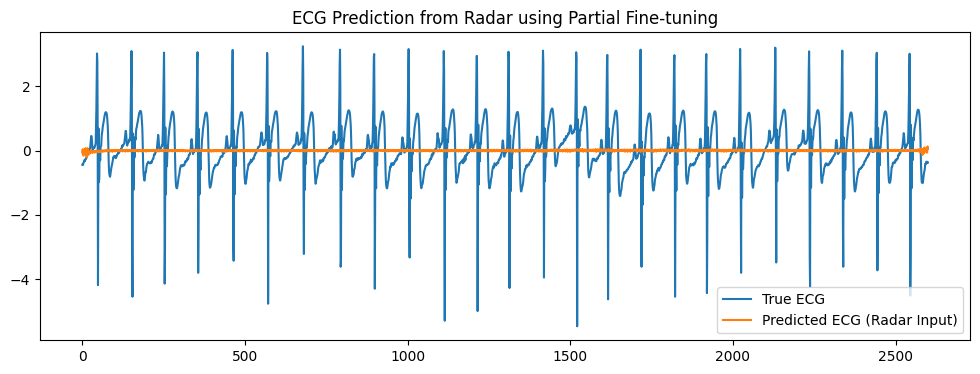

In [17]:
import matplotlib.pyplot as plt

predicted = best_model.predict(hr_test)

plt.figure(figsize=(12, 4))
plt.plot(hr_target_test[0], label='True ECG')
plt.plot(predicted[0], label='Predicted ECG (Radar Input)')
plt.legend()
plt.title("ECG Prediction from Radar using Partial Fine-tuning")
plt.show()

In [18]:
# tuner.search(hr_train[:2400], hr_target_train[:2400], epochs=50, validation_data=(hr_train[2400:], hr_target_train[2400:]), callbacks=[
#         EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     ])
# best_model = tuner.get_best_models(num_models=50)
# # best_model.summary()

In [19]:
# best_hps = tuner.get_best_hyperparameters(num_trials=5)[2]
# print(f"Best hyperparameters:")
# print(f" - Filters: {best_hps.get('filters')}")
# print(f" - Kernel Size: {best_hps.get('kernel_size')}")
# print(f" - Dilation Rates: {best_hps.get('dilation1')}, {best_hps.get('dilation2')}, {best_hps.get('dilation3')}, {best_hps.get('dilation4')}, {best_hps.get('dilation5')}")
# print(f" - Activation: {best_hps.get('activation1')}, {best_hps.get('activation2')}, {best_hps.get('activation3')}, {best_hps.get('activation4')}, {best_hps.get('activation5')}")
# print(f" - Learning Rate: {best_hps.get('learning_rate')}")

In [20]:
# best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]
# best_model_ = tuner.hypermodel.build(best_hps)
# # === Train Best Model ===
# history = best_model_.fit(
#     hr_train, hr_target_train,
#     validation_split=0.2,
#     epochs=200,
#     batch_size=32,
#     verbose=1,
#     # callbacks=[
#     #     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     # ]
# )

In [21]:
# best_model_.save("hr_model_tuner.h5")

In [24]:
from tensorflow.keras.models import load_model

hr_predict = load_model("hr_model_tuner.h5", custom_objects={'mse': 'mean_squared_error'})

An1_HR = np.array(best_model(hr_test[0].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An2_HR = np.array(best_model(hr_test[1].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An3_HR = np.array(best_model(hr_test[2].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An4_HR = np.array(best_model(hr_test[3].reshape(1, -1, 1).astype(np.float64))[0,:,0])

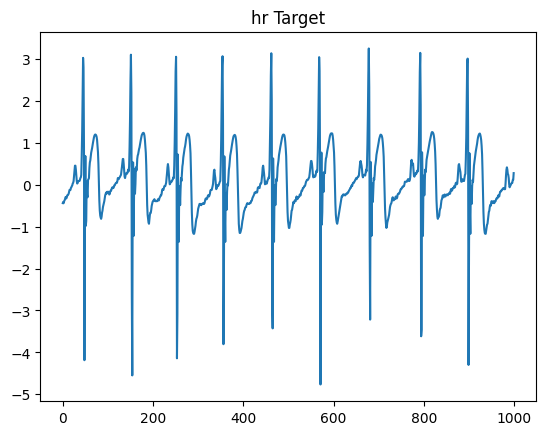

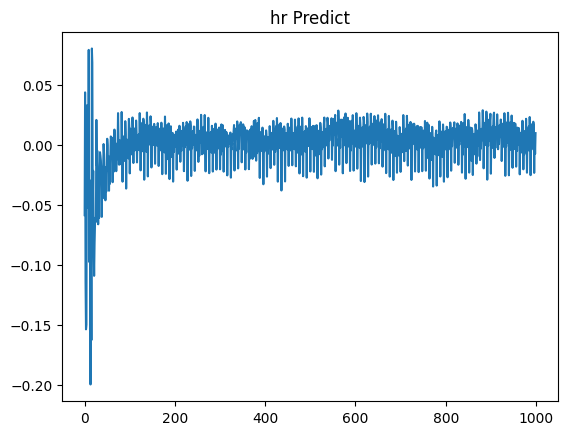

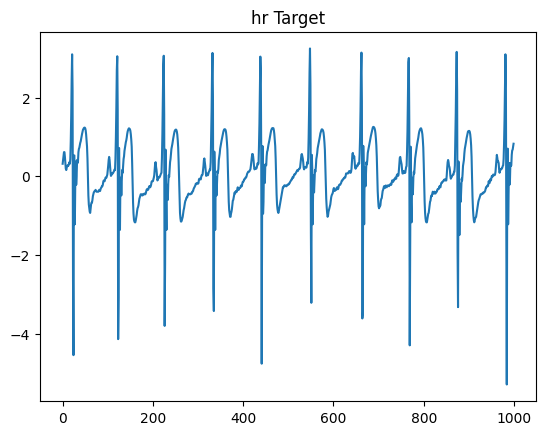

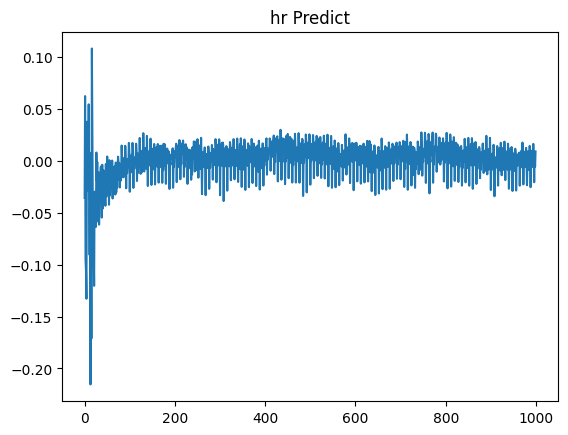

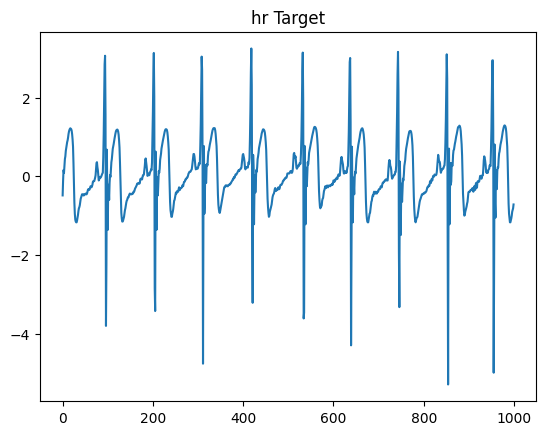

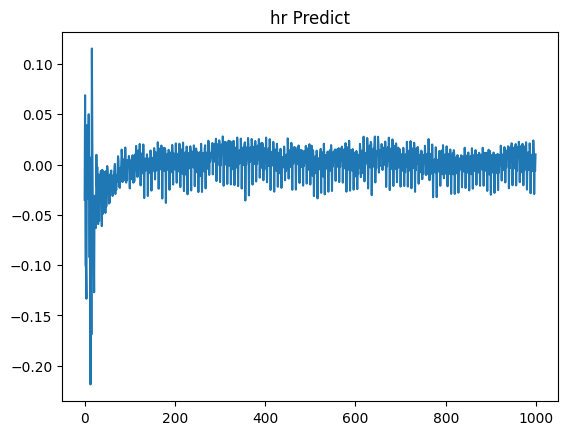

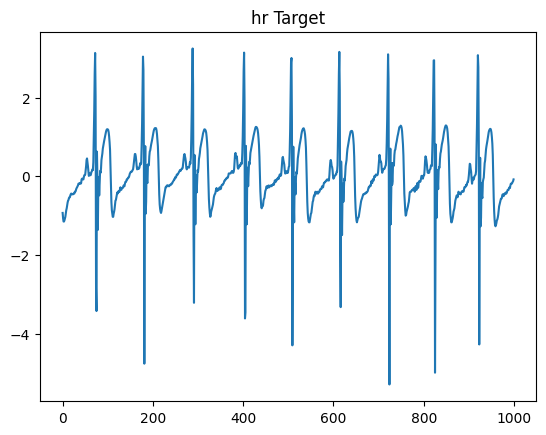

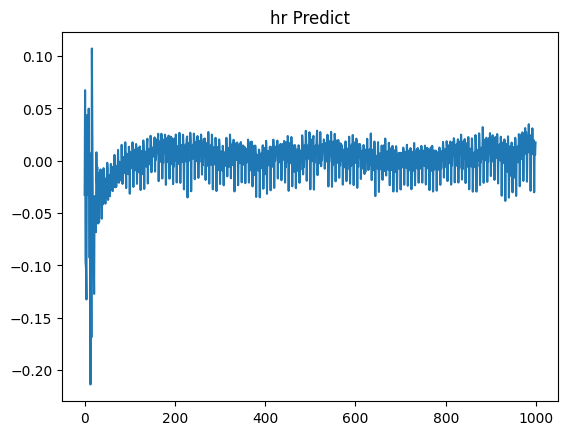

In [25]:
plt.figure(1)
plt.title("hr Target")
plt.plot(hr_target_test[0][:1000],label="hr Target")
plt.figure(2)
plt.title("hr Predict")
plt.plot(An1_HR[:1000],label="hr Predict")
plt.figure(3)
plt.title("hr Target")
plt.plot(hr_target_test[1][:1000],label="hr Target")
plt.figure(4)
plt.title("hr Predict")
plt.plot(An2_HR[:1000],label="hr Predict")
plt.figure(5)
plt.title("hr Target")
plt.plot(hr_target_test[2][:1000],label="hr Target")
plt.figure(6)
plt.title("hr Predict")
plt.plot(An3_HR[:1000],label="hr Predict")
plt.figure(7)
plt.title("hr Target")
plt.plot(hr_target_test[3][:1000],label="hr Target")
plt.figure(8)
plt.title("hr Predict")
plt.plot(An4_HR[:1000],label="hr Predict")